# 金融和经济数据应用

截面（cross-section）：某个时间点的数据  
面板（panel）：多个数据项（例如价格和成交量）在多个时间点的截面数据就构成了一个面板  
面板数据既可以被表示为层次化索引的DataFrame，也可以被表示为三维的Panel pandas对象

## 目录
+ 数据规整化方面的话题
    + 时间序列以及截面对齐
    + 频率不同的时间序列的运算
        + Timestamp
        + Period
    + 时间和“最当前”数据选取
        + at_time方法
        + between_time方法
        + asof方法
    + 拼接多个数据源
        + 在一个特定的时间点上，从一个数据源切换到另一个数据源
        + data1缺失了data2中存在的某个时间序列
            + combine_first方法
            + update方法
        + 利用DataFrame的索引机制直接对列进行设置
    + 收益指数和累计收益


+ 分组变换和分析
    + 分组统计
        + 行业内标准化处理
        + 行业内降序排名
        + 行业内排名的标准化
    + 分组因子暴露
    + 十分位和四分位分析


+ 更多示例应用

In [1]:
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## 数据规整化方面的话题

### 时间序列以及截面对齐
pandas可以在算术运算中自动对齐数据

In [3]:
close_px = pd.read_csv('./data/stock_px.csv', parse_dates=True, index_col=0)
volume = pd.read_csv('./data/volume.csv', parse_dates=True, index_col=0)
prices = close_px.ix['2011-09-05':'2011-09-14', ['AAPL', 'JNJ', 'SPX', 'XOM']]
volume = volume.ix['2011-09-05':'2011-09-12', ['AAPL', 'JNJ', 'XOM']]

In [4]:
prices

,AAPL,JNJ,SPX,XOM
2011-09-06,379.74,64.64,1165.24,71.15
2011-09-07,383.93,65.43,1198.62,73.65
2011-09-08,384.14,64.95,1185.90,72.82
2011-09-09,377.48,63.64,1154.23,71.01
2011-09-12,379.94,63.59,1162.27,71.84
2011-09-13,384.62,63.61,1172.87,71.65
2011-09-14,389.30,63.73,1188.68,72.64


In [5]:
volume

,AAPL,JNJ,XOM
2011-09-06,18173500,15848300,25416300
2011-09-07,12492000,10759700,23108400
2011-09-08,14839800,15551500,22434800
2011-09-09,20171900,17008200,27969100
2011-09-12,16697300,13448200,26205800


In [6]:
prices * volume # pandas会在算术运算过程中自动将数据对齐

,AAPL,JNJ,SPX,XOM
2011-09-06,6901204890,1024434112,NaN,1808369745
2011-09-07,4796053560,704007171,NaN,1701933660
2011-09-08,5700560772,1010069925,NaN,1633702136
2011-09-09,7614488812,1082401848,NaN,1986085791
2011-09-12,6343972162,855171038,NaN,1882624672
2011-09-13,NaN,NaN,NaN,NaN
2011-09-14,NaN,NaN,NaN,NaN


In [7]:
vwap = (prices * volume).sum() / volume.sum() # pandas会在sum这样的函数中排除缺失数据

In [8]:
vwap # 得到每只股票在指定时期的均价

AAPL    380.655181
JNJ      64.394769
SPX            NaN
XOM      72.024288
dtype: float64

In [9]:
vwap.dropna() # SPX在volume中找不到，可以显式地将其丢弃

AAPL    380.655181
JNJ      64.394769
XOM      72.024288
dtype: float64

In [10]:
prices.align(volume, join='inner') # 使用DataFrame的align方法进行手工对齐，返回一个元组，含有两个对象的重索引版本

(              AAPL    JNJ    XOM
 2011-09-06  379.74  64.64  71.15
 2011-09-07  383.93  65.43  73.65
 2011-09-08  384.14  64.95  72.82
 2011-09-09  377.48  63.64  71.01
 2011-09-12  379.94  63.59  71.84,                 AAPL       JNJ       XOM
 2011-09-06  18173500  15848300  25416300
 2011-09-07  12492000  10759700  23108400
 2011-09-08  14839800  15551500  22434800
 2011-09-09  20171900  17008200  27969100
 2011-09-12  16697300  13448200  26205800)

In [11]:
prices.align(volume, join='inner')[0] # 手工对齐后的price

,AAPL,JNJ,XOM
2011-09-06,379.74,64.64,71.15
2011-09-07,383.93,65.43,73.65
2011-09-08,384.14,64.95,72.82
2011-09-09,377.48,63.64,71.01
2011-09-12,379.94,63.59,71.84


In [12]:
prices.align(volume, join='inner')[1] # 手工对齐后的volume

,AAPL,JNJ,XOM
2011-09-06,18173500,15848300,25416300
2011-09-07,12492000,10759700,23108400
2011-09-08,14839800,15551500,22434800
2011-09-09,20171900,17008200,27969100
2011-09-12,16697300,13448200,26205800


In [13]:
s1 = Series(range(3), index=['a', 'b', 'c'])
s2 = Series(range(4), index=['d', 'b', 'c', 'e'])
s3 = Series(range(3), index=['f', 'a', 'c'])
DataFrame({'one': s1, 'two': s2, 'three': s3}) # 通过一组索引不同的Series构建一个DataFrame

,one,three,two
a,0,1,NaN
b,1,NaN,1
c,2,2,2
d,NaN,NaN,0
e,NaN,NaN,3
f,NaN,0,NaN


In [14]:
DataFrame({'one': s1, 'two': s2, 'three': s3}, index=list('face')) # 显式定义结果的索引（丢弃其余的数据）

,one,three,two
f,NaN,0,NaN
a,0,1,NaN
c,2,2,2
e,NaN,NaN,3


### 频率不同的时间序列的运算
频率转换和重对齐的两大主要工具：resample方法和reindex方法
+ resample  
将数据转换到固定频率
+ reindex  
使数据符合一个新索引

#### Timestamp

In [15]:
ts1 = Series(np.random.randn(3),
             index=pd.date_range('2012-6-13', periods=3, freq='W-WED'))
ts1

2012-06-13   -2.216903
2012-06-20    1.319516
2012-06-27   -0.290319
Freq: W-WED, dtype: float64

In [16]:
ts1.resample('B')

2012-06-13   -2.216903
2012-06-14         NaN
2012-06-15         NaN
2012-06-18         NaN
2012-06-19         NaN
2012-06-20    1.319516
2012-06-21         NaN
2012-06-22         NaN
2012-06-25         NaN
2012-06-26         NaN
2012-06-27   -0.290319
Freq: B, dtype: float64

In [17]:
ts1.resample('B', fill_method='ffill')

2012-06-13   -2.216903
2012-06-14   -2.216903
2012-06-15   -2.216903
2012-06-18   -2.216903
2012-06-19   -2.216903
2012-06-20    1.319516
2012-06-21    1.319516
2012-06-22    1.319516
2012-06-25    1.319516
2012-06-26    1.319516
2012-06-27   -0.290319
Freq: B, dtype: float64

In [18]:
dates = pd.DatetimeIndex(['2012-6-12', '2012-6-17', '2012-6-18',
                          '2012-6-21', '2012-6-22', '2012-6-29'])
ts2 = Series(np.random.randn(6), index=dates)
ts2

2012-06-12   -0.017029
2012-06-17    0.287342
2012-06-18    0.678725
2012-06-21   -0.175934
2012-06-22   -0.175914
2012-06-29   -0.083448
dtype: float64

In [19]:
ts1.reindex(ts2.index, method='ffill')

2012-06-12         NaN
2012-06-17   -2.216903
2012-06-18   -2.216903
2012-06-21    1.319516
2012-06-22    1.319516
2012-06-29   -0.290319
dtype: float64

In [20]:
ts2 + ts1.reindex(ts2.index, method='ffill')

2012-06-12         NaN
2012-06-17   -1.929561
2012-06-18   -1.538178
2012-06-21    1.143582
2012-06-22    1.143602
2012-06-29   -0.373768
dtype: float64

#### Period
跟Timestamp的时间序列不同，由Period索引的两个不同频率的时间序列之间的运算必须进行显式转换

In [21]:
gdp = Series([1.78, 1.94, 2.08, 2.01, 2.15, 2.31, 2.46],
             index=pd.period_range('1984Q2', periods=7, freq='Q-SEP'))
infl = Series([0.025, 0.045, 0.037, 0.04],
              index=pd.period_range('1982', periods=4, freq='A-DEC'))
gdp

1984Q2    1.78
1984Q3    1.94
1984Q4    2.08
1985Q1    2.01
1985Q2    2.15
1985Q3    2.31
1985Q4    2.46
Freq: Q-SEP, dtype: float64

In [22]:
infl

1982    0.025
1983    0.045
1984    0.037
1985    0.040
Freq: A-DEC, dtype: float64

In [23]:
infl_q = infl.asfreq('Q-SEP', how='end') # 假设已知infl值是在每年年末观察的，将infl转换到Q-SEP以得到该频率下的正确时间
infl_q

1983Q1    0.025
1984Q1    0.045
1985Q1    0.037
1986Q1    0.040
Freq: Q-SEP, dtype: float64

In [24]:
infl_q.reindex(gdp.index, method='ffill') # 重新索引infl_q时间序列（使用前向填充以匹配gdp）

1984Q2    0.045
1984Q3    0.045
1984Q4    0.045
1985Q1    0.037
1985Q2    0.037
1985Q3    0.037
1985Q4    0.037
Freq: Q-SEP, dtype: float64

### 时间和“最当前”数据选取

In [25]:
# 生成一个交易日内的日期范围和时间序列的索引
rng = pd.date_range('2012-06-01 09:30', '2012-06-01 15:59', freq='T')
# 生成4天的时间点（9:30-15:59之间）
rng = rng.append([rng + pd.offsets.BDay(i) for i in range(1, 4)])
ts = Series(np.arange(len(rng), dtype=float), index=rng)
ts

2012-06-01 09:30:00       0
2012-06-01 09:31:00       1
2012-06-01 09:32:00       2
2012-06-01 09:33:00       3
2012-06-01 09:34:00       4
2012-06-01 09:35:00       5
2012-06-01 09:36:00       6
2012-06-01 09:37:00       7
2012-06-01 09:38:00       8
2012-06-01 09:39:00       9
2012-06-01 09:40:00      10
2012-06-01 09:41:00      11
2012-06-01 09:42:00      12
2012-06-01 09:43:00      13
2012-06-01 09:44:00      14
2012-06-01 09:45:00      15
2012-06-01 09:46:00      16
2012-06-01 09:47:00      17
2012-06-01 09:48:00      18
2012-06-01 09:49:00      19
2012-06-01 09:50:00      20
2012-06-01 09:51:00      21
2012-06-01 09:52:00      22
2012-06-01 09:53:00      23
2012-06-01 09:54:00      24
2012-06-01 09:55:00      25
2012-06-01 09:56:00      26
2012-06-01 09:57:00      27
2012-06-01 09:58:00      28
2012-06-01 09:59:00      29
                       ... 
2012-06-06 15:30:00    1530
2012-06-06 15:31:00    1531
2012-06-06 15:32:00    1532
2012-06-06 15:33:00    1533
2012-06-06 15:34:00 

In [26]:
from datetime import time
ts[time(10, 0)] # 利用Python的datetime.time对象进行索引，即可抽取出这些时间点上的值

2012-06-01 10:00:00      30
2012-06-04 10:00:00     420
2012-06-05 10:00:00     810
2012-06-06 10:00:00    1200
dtype: float64

#### at_time方法

In [27]:
ts.at_time(time(10, 0)) # 实际上，该操作用到了实例方法at_time

2012-06-01 10:00:00      30
2012-06-04 10:00:00     420
2012-06-05 10:00:00     810
2012-06-06 10:00:00    1200
dtype: float64

#### between_time方法

In [28]:
ts.between_time(time(10, 0), time(10, 1)) # between_time方法，用于选取两个Time对象之间的值

2012-06-01 10:00:00      30
2012-06-01 10:01:00      31
2012-06-04 10:00:00     420
2012-06-04 10:01:00     421
2012-06-05 10:00:00     810
2012-06-05 10:01:00     811
2012-06-06 10:00:00    1200
2012-06-06 10:01:00    1201
dtype: float64

#### asof方法
ts中可能刚好没有任何数据落在某个具体的时间上，asof方法能够得到这些时间点处（或其之前最近）的有效值（非NA）

In [29]:
# 将该时间序列的大部分内容随机设置为NA
np.random.seed(12346)
indexer = np.sort(np.random.permutation(len(ts))[700:])
irr_ts = ts.copy()
irr_ts[indexer] = np.nan
irr_ts['2012-06-01 09:50':'2012-06-01 10:00']

2012-06-01 09:50:00    20
2012-06-01 09:51:00   NaN
2012-06-01 09:52:00    22
2012-06-01 09:53:00    23
2012-06-01 09:54:00   NaN
2012-06-01 09:55:00    25
2012-06-01 09:56:00   NaN
2012-06-01 09:57:00   NaN
2012-06-01 09:58:00   NaN
2012-06-01 09:59:00   NaN
2012-06-01 10:00:00   NaN
dtype: float64

In [30]:
selection = pd.date_range('2012-06-01 10:00', periods=4, freq='B')
selection

DatetimeIndex(['2012-06-01 10:00:00', '2012-06-04 10:00:00',
               '2012-06-05 10:00:00', '2012-06-06 10:00:00'],
              dtype='datetime64[ns]', freq='B')

In [31]:
irr_ts.asof(selection) # asof方法能够得到指定时间点处（或其之前最近）的有效值（非NA）

2012-06-01 10:00:00      25
2012-06-04 10:00:00     420
2012-06-05 10:00:00     810
2012-06-06 10:00:00    1197
Freq: B, dtype: float64

### 拼接多个数据源
+ 在一个特定的时间点上，从一个数据源切换到另一个数据源
+ 用另一个时间序列对当前时间序列中的缺失值“打补丁”
+ 将数据中的符号（国家、资产代码等）替换为实际数据

#### 在一个特定的时间点上，从一个数据源切换到另一个数据源
pd.concat函数

In [32]:
data1 = DataFrame(np.ones((6, 3), dtype=float),
                  columns=['a', 'b', 'c'],
                  index=pd.date_range('6/12/2012', periods=6))
data1

,a,b,c
2012-06-12,1,1,1
2012-06-13,1,1,1
2012-06-14,1,1,1
2012-06-15,1,1,1
2012-06-16,1,1,1
2012-06-17,1,1,1


In [33]:
data2 = DataFrame(np.ones((6, 3), dtype=float) * 2,
                  columns=['a', 'b', 'c'],
                  index=pd.date_range('6/13/2012', periods=6))
data2

,a,b,c
2012-06-13,2,2,2
2012-06-14,2,2,2
2012-06-15,2,2,2
2012-06-16,2,2,2
2012-06-17,2,2,2
2012-06-18,2,2,2


In [34]:
spliced = pd.concat([data1.ix[:'2012-06-14'], data2.ix['2012-06-15':]]) # 用concat将两个TimeSeries或DataFrame对象合并到一起
spliced

,a,b,c
2012-06-12,1,1,1
2012-06-13,1,1,1
2012-06-14,1,1,1
2012-06-15,2,2,2
2012-06-16,2,2,2
2012-06-17,2,2,2
2012-06-18,2,2,2


#### data1缺失了data2中存在的某个时间序列

##### combine_first方法

In [35]:
data2 = DataFrame(np.ones((6, 4), dtype=float) * 2,
                  columns=['a', 'b', 'c', 'd'],
                  index=pd.date_range('6/13/2012', periods=6))
data2

,a,b,c,d
2012-06-13,2,2,2,2
2012-06-14,2,2,2,2
2012-06-15,2,2,2,2
2012-06-16,2,2,2,2
2012-06-17,2,2,2,2
2012-06-18,2,2,2,2


In [36]:
spliced = pd.concat([data1.ix[:'2012-06-14'], data2.ix['2012-06-15':]])
spliced

,a,b,c,d
2012-06-12,1,1,1,NaN
2012-06-13,1,1,1,NaN
2012-06-14,1,1,1,NaN
2012-06-15,2,2,2,2
2012-06-16,2,2,2,2
2012-06-17,2,2,2,2
2012-06-18,2,2,2,2


In [37]:
spliced_filled = spliced.combine_first(data2) # combine_first可以引入合并点之前的数据，从而扩展'd'项的历史
spliced_filled

,a,b,c,d
2012-06-12,1,1,1,NaN
2012-06-13,1,1,1,2
2012-06-14,1,1,1,2
2012-06-15,2,2,2,2
2012-06-16,2,2,2,2
2012-06-17,2,2,2,2
2012-06-18,2,2,2,2


##### update方法

In [38]:
spliced.update(data2, overwrite=False) # update可以实现就地更新，如果只想填充空洞，则传入overwrite=False参数

In [39]:
spliced

,a,b,c,d
2012-06-12,1,1,1,NaN
2012-06-13,1,1,1,2
2012-06-14,1,1,1,2
2012-06-15,2,2,2,2
2012-06-16,2,2,2,2
2012-06-17,2,2,2,2
2012-06-18,2,2,2,2


#### 利用DataFrame的索引机制直接对列进行设置

In [40]:
cp_spliced = spliced.copy()
cp_spliced

,a,b,c,d
2012-06-12,1,1,1,NaN
2012-06-13,1,1,1,2
2012-06-14,1,1,1,2
2012-06-15,2,2,2,2
2012-06-16,2,2,2,2
2012-06-17,2,2,2,2
2012-06-18,2,2,2,2


In [41]:
cp_spliced[['a', 'c']] = data1[['a', 'c']]
cp_spliced

,a,b,c,d
2012-06-12,1,1,1,NaN
2012-06-13,1,1,1,2
2012-06-14,1,1,1,2
2012-06-15,1,2,1,2
2012-06-16,1,2,1,2
2012-06-17,1,2,1,2
2012-06-18,NaN,2,NaN,2


### 收益指数和累计收益

In [42]:
import pandas_datareader.data as web
price = web.get_data_yahoo('AAPL', '2011-01-01')['Adj Close']
price[-5:]

Date
2016-05-18    94.559998
2016-05-19    94.199997
2016-05-20    95.220001
2016-05-23    96.430000
2016-05-24    97.900002
Name: Adj Close, dtype: float64

In [43]:
price['2011-10-03'] / price['2011-3-01'] - 1 # 计算两个时间点之间的累计百分比回报

0.072399882142698768

In [44]:
returns = price.pct_change()
ret_index = (1 + returns).cumprod()
ret_index[0] = 1  # 将第一个值设置为1
ret_index # 收益指数

Date
2011-01-03    1.000000
2011-01-04    1.005219
2011-01-05    1.013442
2011-01-06    1.012622
2011-01-07    1.019874
2011-01-10    1.039081
2011-01-11    1.036623
2011-01-12    1.045059
2011-01-13    1.048882
2011-01-14    1.057378
2011-01-18    1.033620
2011-01-19    1.028128
2011-01-20    1.009437
2011-01-21    0.991352
2011-01-24    1.023910
2011-01-25    1.035895
2011-01-26    1.043329
2011-01-27    1.041387
2011-01-28    1.019814
2011-01-31    1.029584
2011-02-01    1.046910
2011-02-02    1.044755
2011-02-03    1.042085
2011-02-04    1.051370
2011-02-07    1.067694
2011-02-08    1.077768
2011-02-09    1.086749
2011-02-10    1.075765
2011-02-11    1.082775
2011-02-14    1.089844
                ...   
2016-04-13    2.569630
2016-04-14    2.571006
2016-04-15    2.519403
2016-04-18    2.465047
2016-04-19    2.451974
2016-04-20    2.457019
2016-04-21    2.430415
2016-04-22    2.423764
2016-04-25    2.410003
2016-04-26    2.393260
2016-04-27    2.243495
2016-04-28    2.174920
2016-0

In [45]:
m_returns = ret_index.resample('BM', how='last').pct_change() # 计算每月的累计收益率
m_returns['2012'] # 获取2012年的每月累计收益率

Date
2012-01-31    0.127111
2012-02-29    0.188311
2012-03-30    0.105283
2012-04-30   -0.025970
2012-05-31   -0.010702
2012-06-29    0.010853
2012-07-31    0.045822
2012-08-31    0.093877
2012-09-28    0.002796
2012-10-31   -0.107600
2012-11-30   -0.012375
2012-12-31   -0.090743
Freq: BM, Name: Adj Close, dtype: float64

In [46]:
m_rets = (1 + returns).resample('M', how='prod', kind='period') - 1 # 以上结果也能通过重采样聚合（这里聚合为时期）从日百分比变化中计算得出
m_rets['2012']

Date
2012-01    0.127111
2012-02    0.188311
2012-03    0.105283
2012-04   -0.025970
2012-05   -0.010702
2012-06    0.010853
2012-07    0.045822
2012-08    0.093877
2012-09    0.002796
2012-10   -0.107600
2012-11   -0.012375
2012-12   -0.090743
Freq: M, Name: Adj Close, dtype: float64

## 分组变换和分析

In [47]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 10
np.random.seed(12345)

In [48]:
import random; random.seed(0)
import string

N = 1000
def rands(n):
    choices = string.ascii_uppercase # 生成'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    return ''.join([random.choice(choices) for _ in xrange(n)]) # 随机选取n个字母拼接在一起
tickers = np.array([rands(5) for _ in xrange(N)]) # 随机生成1000个5位大写字母的股票代码

In [49]:
M = 500
df = DataFrame({'Momentum' : np.random.randn(M) / 200 + 0.03,
                'Value' : np.random.randn(M) / 200 + 0.08,
                'ShortInterest' : np.random.randn(M) / 200 - 0.02},
                index=tickers[:M]) # 创建一个含有3列的DataFrame来承载这些假想数据，只选择500只股票组成该投资组合

In [50]:
ind_names = np.array(['FINANCIAL', 'TECH']) # 创建行业分类
sampler = np.random.randint(0, len(ind_names), N)
industries = Series(ind_names[sampler], index=tickers,
                    name='industry') # 为1000只股票随机分配行业，并保存在Series中

### 分组统计

In [51]:
by_industry = df.groupby(industries) # 根据行业分类进行分组并执行分组聚合和变换
by_industry.mean() # 根据行业分类求平均值

,Momentum,ShortInterest,Value
industry,,,
FINANCIAL,0.029485,-0.020739,0.079929
TECH,0.030407,-0.019609,0.080113


In [52]:
by_industry.describe() # 获取行业分类的统计量

Momentum  ShortInterest       Value
industry                                              
FINANCIAL count  246.000000     246.000000  246.000000
          mean     0.029485      -0.020739    0.079929
          std      0.004802       0.004986    0.004548
          min      0.017210      -0.036997    0.067025
          25%      0.026263      -0.024138    0.076638
          50%      0.029261      -0.020833    0.079804
          75%      0.032806      -0.017345    0.082718
          max      0.045884      -0.006322    0.093334
TECH      count  254.000000     254.000000  254.000000
          mean     0.030407      -0.019609    0.080113
          std      0.005303       0.005074    0.004886
          min      0.016778      -0.032682    0.065253
          25%      0.026456      -0.022779    0.076737
          50%      0.030650      -0.019829    0.080296
          75%      0.033602      -0.016923    0.083353
          max      0.049638      -0.003698    0.093081

#### 行业内标准化处理

In [53]:
def zscore(group):
    return (group - group.mean()) / group.std()

df_stand = by_industry.apply(zscore)

In [54]:
df_stand.groupby(industries).agg(['mean', 'std']) # 处理后，各行业的平均值为0，标准差为1

Momentum     ShortInterest             Value    
                   mean std          mean std          mean std
industry                                                       
FINANCIAL  1.114736e-15   1  3.081772e-15   1  8.001278e-15   1
TECH      -2.779929e-16   1 -1.910982e-15   1 -7.139521e-15   1

#### 行业内降序排名

In [55]:
ind_rank = by_industry.rank(ascending=False)
ind_rank.groupby(industries).agg(['min', 'max'])

Momentum      ShortInterest      Value     
               min  max           min  max   min  max
industry                                             
FINANCIAL        1  246             1  246     1  246
TECH             1  254             1  254     1  254

#### 行业内排名的标准化

In [56]:
by_industry.apply(lambda x: zscore(x.rank()))

,Momentum,ShortInterest,Value
VTKGN,-0.091346,-0.976696,-1.004802
KUHMP,0.794005,1.299919,-0.358356
XNHTQ,-0.541047,-0.836164,-1.679355
GXZVX,-0.583207,-1.623142,0.990749
ISXRM,1.572120,-0.265423,0.374314
CLPXZ,1.395171,0.360703,-1.436006
MWGUO,-0.074863,0.632931,-0.660154
ASKVR,0.238200,-0.319869,0.102086
AMWGI,1.075068,1.665302,1.580983
WEOGZ,1.412345,0.358356,-1.313972


### 分组因子暴露
+ 因子分析是投资组合定量管理中的一种技术  
+ 投资组合的持有量和性能（收益与损失）可以被分解为一个或多个表示投资组合权重的因子（风险因子就是其中之一）  
+ 例如，某只股票的价格与某个基准（比如标准普尔500指数）的协动性被称作其贝塔风险系数（beta，一种常见的风险因子）

In [57]:
from numpy.random import rand
fac1, fac2, fac3 = np.random.rand(3, 1000) # fac1,fac2,fac3分别是由1000个[0,1)内的数组成的数组

ticker_subset = tickers.take(np.random.permutation(N)[:1000]) # 将1000只股票的顺序打乱

# 因子加权和以及噪声
port = Series(0.7 * fac1 - 1.2 * fac2 + 0.3 * fac3 + rand(1000),
              index=ticker_subset) # 3因子加权和，再加上噪声（服从[0,1)）
factors = DataFrame({'f1': fac1, 'f2': fac2, 'f3': fac3},
                    index=ticker_subset) # 产生3因子DataFrame

In [58]:
factors.corrwith(port) # 分别计算port与factors中3因子的相关系数

f1    0.402377
f2   -0.680980
f3    0.168083
dtype: float64

In [59]:
pd.ols(y=port, x=factors).beta # 计算因子暴露（系数）的标准方式是最小二乘回归，使用pd.ols函数，并通过beta属性，计算整个投资组合的暴露（系数）

f1           0.761789
f2          -1.208760
f3           0.289865
intercept    0.484477
dtype: float64

In [60]:
def beta_exposure(chunk, factors=None):
    return pd.ols(y=chunk, x=factors).beta # 计算各行业的因子暴露

In [61]:
by_ind = port.groupby(industries)
exposures = by_ind.apply(beta_exposure, factors=factors)
exposures.unstack()

,f1,f2,f3,intercept
industry,,,,
FINANCIAL,0.790329,-1.182970,0.275624,0.455569
TECH,0.740857,-1.232882,0.303811,0.508188


### 十分位和四分位分析
+ pandas.qcut和groupby  
+ 基于样本分位数的分析是金融分析师的另一个重要工具  
+ 例如，股票投资组合的性能可以根据各股的市盈率被划分入四分位

In [62]:
import pandas_datareader.data as web
data = web.get_data_yahoo('SPY', '2006-01-01', '2012-07-27')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1655 entries, 2006-01-03 to 2012-07-27
Data columns (total 6 columns):
Open         1655 non-null float64
High         1655 non-null float64
Low          1655 non-null float64
Close        1655 non-null float64
Volume       1655 non-null int64
Adj Close    1655 non-null float64
dtypes: float64(5), int64(1)
memory usage: 90.5 KB


In [63]:
# 计算日收益率，并编写一个用于将收益率变换为趋势信号（通过滞后移动形成）的函数
px = data['Adj Close']
returns = px.pct_change()

def to_index(rets):
    index = (1 + rets).cumprod()
    first_loc = max(index.index.get_loc(index.idxmax()) - 1, 0)
    index.values[first_loc] = 1
    return index

def trend_signal(rets, lookback, lag):
    signal = pd.rolling_sum(rets, lookback, min_periods=lookback - 5)
    return signal.shift(lag)

In [64]:
# 通过该函数，创建和测试一种根据每周五动量信号进行交易的交易策略
signal = trend_signal(returns, 100, 3)
trade_friday = signal.resample('W-FRI').resample('B', fill_method='ffill')
trade_rets = trade_friday.shift(1) * returns
trade_rets = trade_rets[:len(returns)]

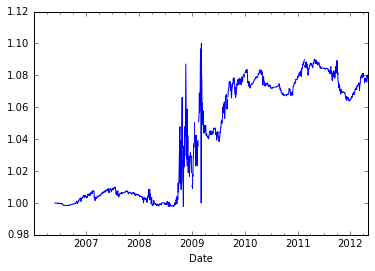

In [65]:
# 将该策略转换为一个收益指数，并绘制一张图表
to_index(trade_rets).plot()

In [66]:
# 将该策略的性能按不同大小的交易期波幅进行划分，年度标准差是计算波幅的一种简单方法，可以通过计算夏普比率来观察不同波动机制下的风险收益率
vol = pd.rolling_std(returns, 250, min_periods=200) * np.sqrt(250)

def sharpe(rets, ann=250):
    return rets.mean() / rets.std()  * np.sqrt(ann)

In [67]:
# 利用qcut将vol划分为四等份，并用sharpe进行聚合
cats = pd.qcut(vol, 4)
print('cats: %d, trade_rets: %d, vol: %d' % (len(cats), len(trade_rets), len(vol)))

cats: 1655, trade_rets: 1655, vol: 1655


In [68]:
trade_rets.groupby(cats).agg(sharpe)

Adj Close
[0.0954, 0.16]   -0.012379
(0.16, 0.188]     0.278561
(0.188, 0.231]   -0.154232
(0.231, 0.457]    0.526424
Name: Adj Close, dtype: float64

## 更多示例应用

### Signal frontier analysis

In [69]:
names = ['AAPL', 'GOOG', 'MSFT', 'DELL', 'GS', 'MS', 'BAC', 'C']
def get_px(stock, start, end):
    return web.get_data_yahoo(stock, start, end)['Adj Close']
px = DataFrame({n: get_px(n, None, None) for n in names})

In [70]:
#px = pd.read_csv('ch11/stock_px.csv')

In [71]:
plt.close('all')

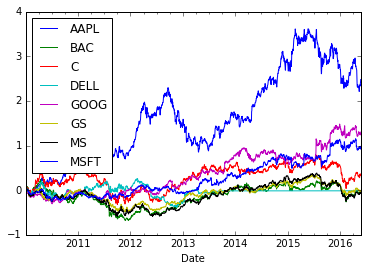

In [72]:
px = px.asfreq('B').fillna(method='pad')
rets = px.pct_change()
((1 + rets).cumprod() - 1).plot()

In [73]:
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

In [74]:
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)

    daily_rets = prices.pct_change()

    # Compute portfolio returns
    port = port.shift(1).resample(freq, how='first')
    returns = daily_rets.resample(freq, how=compound)
    port_rets = (port * returns).sum(axis=1)

    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [75]:
strat_sr(px, 70, 30)

-0.13254028978020943

In [76]:
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(px, lb, hold)

ddf = DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [77]:
import matplotlib.pyplot as plt

def heatmap(df, cmap=plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

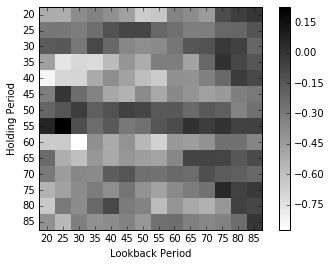

In [78]:
heatmap(ddf)

### Future contract rolling

In [79]:
pd.options.display.max_rows = 10

In [80]:
import pandas_datareader.data as web
# Approximate price of S&P 500 index
px = web.get_data_yahoo('SPY')['Adj Close'] * 10
px

Date
2010-01-04     998.08658
2010-01-05    1000.72861
2010-01-06    1001.43318
2010-01-07    1005.66052
2010-01-08    1009.00712
                 ...    
2016-05-18    2049.10004
2016-05-19    2041.99997
2016-05-20    2054.90005
2016-05-23    2052.10007
2016-05-24    2078.69995
Name: Adj Close, dtype: float64

In [81]:
from datetime import datetime
expiry = {'ESU2': datetime(2012, 9, 21),
          'ESZ2': datetime(2012, 12, 21)}
expiry = Series(expiry).sort_values()

In [82]:
expiry

ESU2   2012-09-21
ESZ2   2012-12-21
dtype: datetime64[ns]

In [83]:
np.random.seed(12347)
N = 200
walk = (np.random.randint(0, 200, size=N) - 100) * 0.25
perturb = (np.random.randint(0, 20, size=N) - 10) * 0.25
walk = walk.cumsum()

rng = pd.date_range(px.index[0], periods=len(px) + N, freq='B')
near = np.concatenate([px.values, px.values[-1] + walk])
far = np.concatenate([px.values, px.values[-1] + walk + perturb])
prices = DataFrame({'ESU2': near, 'ESZ2': far}, index=rng)

In [84]:
prices.tail()

,ESU2,ESZ2
2016-12-02,2107.94995,2109.69995
2016-12-05,2094.19995,2096.44995
2016-12-06,2102.19995,2103.94995
2016-12-07,2118.69995,2117.94995
2016-12-08,2098.69995,2096.44995


In [85]:
def get_roll_weights(start, expiry, items, roll_periods=5):
    # start : first date to compute weighting DataFrame
    # expiry : Series of ticker -> expiration dates
    # items : sequence of contract names

    dates = pd.date_range(start, expiry[-1], freq='B')
    weights = DataFrame(np.zeros((len(dates), len(items))),
                        index=dates, columns=items)

    prev_date = weights.index[0]
    for i, (item, ex_date) in enumerate(expiry.iteritems()):
        if i < len(expiry) - 1:
            weights.ix[prev_date:ex_date - pd.offsets.BDay(), item] = 1
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
                                     periods=roll_periods + 1, freq='B')

            decay_weights = np.linspace(0, 1, roll_periods + 1)
            weights.ix[roll_rng, item] = 1 - decay_weights
            weights.ix[roll_rng, expiry.index[i + 1]] = decay_weights
        else:
            weights.ix[prev_date:, item] = 1

        prev_date = ex_date

    return weights

In [86]:
weights = get_roll_weights('6/1/2012', expiry, prices.columns)
weights.ix['2012-09-12':'2012-09-21']

,ESU2,ESZ2
2012-09-12,1.0,0.0
2012-09-13,1.0,0.0
2012-09-14,0.8,0.2
2012-09-17,0.6,0.4
2012-09-18,0.4,0.6
2012-09-19,0.2,0.8
2012-09-20,0.0,1.0
2012-09-21,0.0,1.0


In [87]:
rolled_returns = (prices.pct_change() * weights).sum(1)

### Rolling correlation and linear regression

In [88]:
aapl = web.get_data_yahoo('AAPL', '2000-01-01')['Adj Close']
msft = web.get_data_yahoo('MSFT', '2000-01-01')['Adj Close']

aapl_rets = aapl.pct_change()
msft_rets = msft.pct_change()

In [89]:
plt.figure()

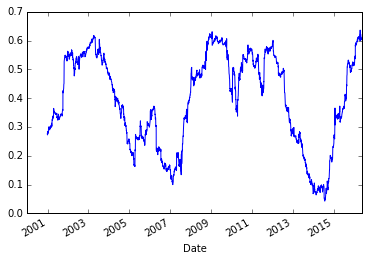

In [90]:
pd.rolling_corr(aapl_rets, msft_rets, 250).plot()

In [91]:
plt.figure()

In [92]:
model = pd.ols(y=aapl_rets, x={'MSFT': msft_rets}, window=250)
model.beta

,MSFT,intercept
Date,,
2000-12-28,0.429021,-0.002113
2000-12-29,0.421102,-0.001796
2001-01-02,0.420595,-0.001839
2001-01-03,0.433292,-0.001289
2001-01-04,0.432772,-0.001307
...,...,...
2016-05-18,0.629733,-0.001410
2016-05-19,0.631925,-0.001465
2016-05-20,0.630930,-0.001365


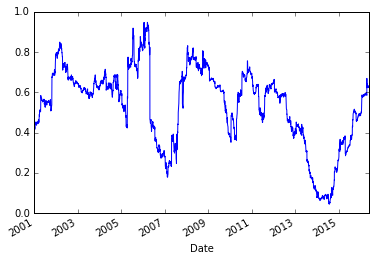

In [93]:
model.beta['MSFT'].plot()